## Дз 8: "Metric learning"

## Цель задания:
Познакомится с алгоритмами metric learning
## Описание задания:
В рамках данного домашнего задания предлагается решить задачу поиска похожего автомобиля в базе данных (автомобиля того же класса). На основе датасета [cars196](https://paperswithcode.com/sota/metric-learning-on-cars196) , ссылка на данные [мета](https://drive.google.com/file/d/1PD-lbbcKSelDeAYKafe3boc5mqqEe7X7/view?usp=sharing) [data](https://drive.google.com/file/d/1l9EnYMC-xGX706SY1kN8RceMmFViASfx/view?usp=sharing).

Процесс выполнения задания следующий:

0. Выбор модели эмбеддера:
    1. Выберите модель кодирующую изображения для выполнения домашнего задания. Любую, кроме модели resnet50.

1. Подготовка обучающего набора данных
    1. Реализуйте корректный класс Dataset и Dataloader для выбранной модели (должен работать форвард вашей модели на том, что выходит из даталоадера).
    2. Добавьте аугментации в датасет **0.5 балла**.

2. Реализация корректного train-loop и обучение модели:  
    1. Реализуйте train-loop для вашей модели и проведите обучение c Triplet loss **2 балла**.
    2. При формировании триплета не просто брать отрицательный класс, а воспользоваться техникой hard negative mining **0.5 балла**.
    3. Обучите модель и воcпользуйте иными loss функциями для задачи metric learning **0.5 балла**.
    4. Полезные ссылки [тык](https://github.com/KevinMusgrave/pytorch-metric-learning)
 
3. Валидация обученных моделей на тестовой выборке, вычисление метрики Recall и Precision
    1. Оцените качество моделей на тестовой части данных и рассчитайте метрики поиска Recall@1, Recall@5, Precision@1, Precision@5. Обратите внимание, что для формирования предсказаний на тестовой выборке вы не должны предсказывать напрямую класс объекта, а должны производить поиск на основе получившихся эмбеддингов (пример в [семинаре](metric_learning.ipynb) блок Faiss). **0.5 балла**
    2. При поиске воспользоваться библиотекой Faiss **0.5 балла**

4. Выводы:
    1. Проанализируйте результаты обучения, визуально оцените качество работы модели.
    2. Прокомментируйте распространенные ошибки модели и предложите пути для улучшения финального решения.
    3. Проинтерпретируйте результаты работы модели с помощью [GradCam](https://github.com/jacobgil/pytorch-grad-cam)  **0.5 балла**


In [1]:
import cv2
import os
import random

from tqdm import tqdm
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.distributions.categorical import Categorical
from torchvision import datasets, transforms
from torchvision.transforms import Compose, ToTensor, Resize, Normalize
from torchvision.models import vit_l_32, vit_b_16

from pytorch_metric_learning import distances, losses, miners, reducers, testers
from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator

import faiss

from PIL import Image
import matplotlib.pyplot as plt
import scipy.io

import warnings

warnings.filterwarnings("ignore")

ADD_PATH = "./cars_train/cars_train"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
import scipy.io

mat = scipy.io.loadmat("./devkit/cars_train_annos.mat")
fname_to_class = {
    fname: cl - 1
    for fname, cl in zip(
        [i[0] for i in mat["annotations"][0]["fname"]],
        [i[0][0] for i in mat["annotations"][0]["class"]],
    )
}
cars_meta = scipy.io.loadmat("./devkit/cars_meta.mat")
id_to_car = {idx: car[0] for idx, car in enumerate(cars_meta["class_names"][0])}

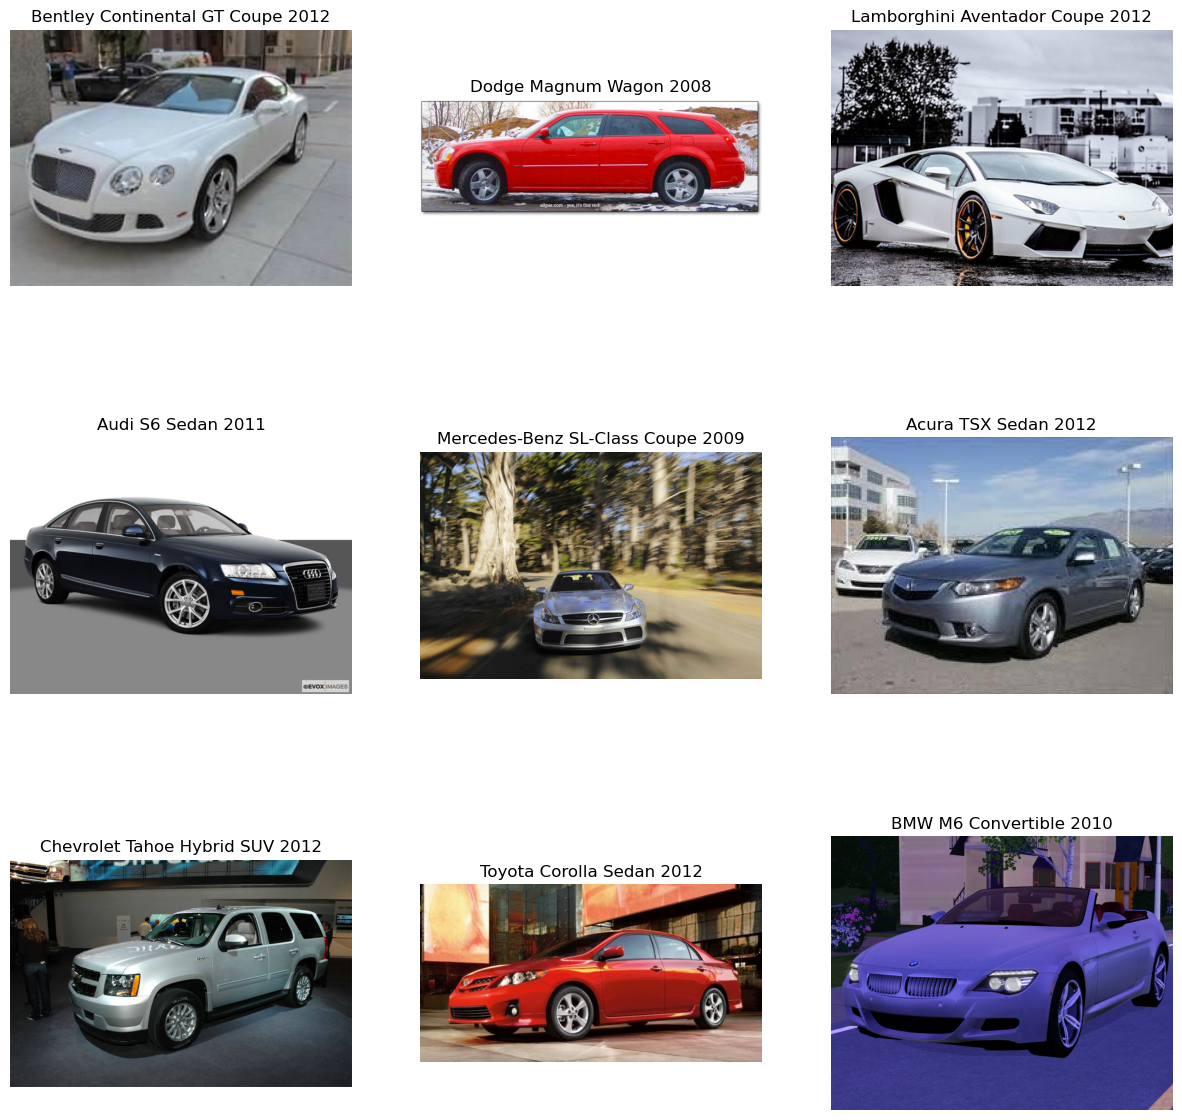

In [3]:
num_imgs = 9
cols = 3
rows = num_imgs // cols
fig, ax = plt.subplots(rows, cols, figsize=(15, 15))
for idx, im_idx in enumerate(
    random.sample([i for i in range(len(fname_to_class))], num_imgs)
):
    filename, cl_id = list(fname_to_class.items())[im_idx]
    temp_image = cv2.imread(os.path.join(ADD_PATH, filename))
    temp_image = cv2.cvtColor(temp_image, cv2.COLOR_BGR2RGB)
    ax[idx // cols][idx % cols].imshow(temp_image)
    ax[idx // cols][idx % cols].set_title(f"{id_to_car[cl_id]}")
    ax[idx // cols][idx % cols].axis("off")

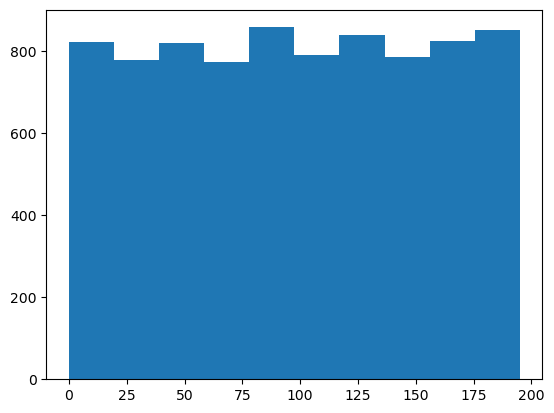

In [4]:
plt.hist(fname_to_class.values())
plt.show()

In [5]:
class CarDataset(Dataset):
    def __init__(self, images_path, meta_path, transforms=None):
        super().__init__()
        self.images_path = images_path
        self.meta_path = meta_path
        self.transforms = transforms
        self.meta = scipy.io.loadmat(self.meta_path)["annotations"][0]
        meta = []
        for i in tqdm(range(len(self.meta))):
            if self[i] is not None:
                meta.append(self.meta[i])
        self.meta = meta

    def __len__(self):
        return len(self.meta)

    def __getitem__(self, index):
        try:
            fname = str(self.meta[index]["fname"][0])
            x1 = int(self.meta[index]["bbox_x1"][0])
            y1 = int(self.meta[index]["bbox_y1"][0])
            x2 = int(self.meta[index]["bbox_x2"][0])
            y2 = int(self.meta[index]["bbox_y2"][0])

            target = torch.LongTensor(self.meta[index]["class"][0])
            image = Image.open(os.path.join(self.images_path, fname))
            image = image.crop((x1, y1, x2, y2))
            if self.transforms:
                image = self.transforms(image)
            if image.shape[0] == 1:
                image = torch.cat([image, image, image])
            return image, target
        except Exception as e:
            print(e)
            return None

In [7]:
def calculate_embeddings(data, model):
    base_tester = testers.BaseTester(dataloader_num_workers=0)
    return base_tester.get_all_embeddings(data, model)


def train(
    model, train_loader, loss_function, mining_function, optimizer, epoch, device
):
    model.to(device)
    model.train()

    for _, (data, target) in enumerate(tqdm(train_loader)):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        mining_idx = mining_function(output, target.squeeze(-1))
        loss = loss_function(output, target.squeeze(-1), mining_idx)
        loss.backward()
        optimizer.step()

    print(f"Epoch: {epoch}, train loss: {loss.item()}")


def validation(model, train_data, test_data, accuracy_calculator, device):
    model.to(device)
    model.eval()
    train_embs, train_target = calculate_embeddings(train_data, model)
    test_embs, test_target = calculate_embeddings(test_data, model)
    train_target, test_target = train_target.squeeze(1), test_target.squeeze(1)

    print("Calculating accuracy")
    test_accuracy = accuracy_calculator.get_accuracy(
        test_embs, test_target, train_embs, train_target, False
    )
    print("Test set: Accuracy: {:.4f}".format(test_accuracy["precision_at_1"]))

In [8]:
transforms = Compose([Resize((224, 224)), ToTensor()])

dataset = CarDataset(
    images_path="cars_train/cars_train/",
    meta_path="devkit/cars_train_annos.mat",
    transforms=transforms,
)

splitting_probs = Categorical(torch.Tensor([0.7, 0.3]))
splited_dataset = splitting_probs.sample(sample_shape=[len(dataset)])
train_dataset = torch.utils.data.Subset(dataset, torch.where(splited_dataset == 0)[0])
test_dataset = torch.utils.data.Subset(dataset, torch.where(splited_dataset == 1)[0])

batch_size = 128
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True,
)
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    drop_last=True,
)

  0%|          | 0/8144 [00:00<?, ?it/s]

In [9]:
model = vit_b_16(pretrained=True)
model.heads = nn.Linear(768, 768)
optimizer = optim.Adam(model.parameters(), lr=1e-5)

In [10]:
distance = distances.CosineSimilarity()

reducer = reducers.ThresholdReducer(low=0)
loss_func = losses.TripletMarginLoss(margin=0.15, distance=distance, reducer=reducer)
mining_func = miners.TripletMarginMiner(
    margin=0.15, distance=distance, type_of_triplets="semihard"
)

metrics = []
accuracy_calculator = AccuracyCalculator(include=("precision_at_1",), k=1)

for epoch in range(0, 10):
    train(
        model=model,
        train_loader=train_loader,
        loss_function=loss_func,
        mining_function=mining_func,
        optimizer=optimizer,
        epoch=epoch,
        device=device,
    )
    print("Start validation")
    validation(
        model=model,
        train_data=train_dataset,
        test_data=test_dataset,
        accuracy_calculator=accuracy_calculator,
        device=device,
    )

  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 0, train loss: 0.068143829703331
Start validation


100%|██████████| 77/77 [00:15<00:00,  5.05it/s]

Calculating accuracy
Test set: Accuracy: 0.4089


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 1, train loss: 0.07097664475440979
Start validation


100%|██████████| 77/77 [00:15<00:00,  5.11it/s]

Calculating accuracy
Test set: Accuracy: 0.4700


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 2, train loss: 0.07024450600147247
Start validation


100%|██████████| 77/77 [00:15<00:00,  4.99it/s]

Calculating accuracy
Test set: Accuracy: 0.4965


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 3, train loss: 0.06799659878015518
Start validation


100%|██████████| 77/77 [00:16<00:00,  4.79it/s]


Calculating accuracy
Test set: Accuracy: 0.5259


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 4, train loss: 0.06548608839511871
Start validation


100%|██████████| 77/77 [00:15<00:00,  4.94it/s]

Calculating accuracy
Test set: Accuracy: 0.5801


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 5, train loss: 0.06872792541980743
Start validation


100%|██████████| 77/77 [00:15<00:00,  5.01it/s]


Calculating accuracy
Test set: Accuracy: 0.6131


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 6, train loss: 0.0630764588713646
Start validation


100%|██████████| 77/77 [00:15<00:00,  5.01it/s]


Calculating accuracy
Test set: Accuracy: 0.6258


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 7, train loss: 0.06262633949518204
Start validation


100%|██████████| 77/77 [00:15<00:00,  5.02it/s]

Calculating accuracy
Test set: Accuracy: 0.6192


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 8, train loss: 0.06396043300628662
Start validation


100%|██████████| 77/77 [00:15<00:00,  5.00it/s]

Calculating accuracy
Test set: Accuracy: 0.6470


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 9, train loss: 0.0646807849407196
Start validation


100%|██████████| 77/77 [00:15<00:00,  4.86it/s]

Calculating accuracy
Test set: Accuracy: 0.6474


In [11]:
torch.save(model.state_dict(), "vit_b_16-20_epochs.pth")

Поиск с помощью faiss

In [12]:
import numpy as np


def evaluate(index, train_labels, test_embeddings, test_labels, k):
    D, I = index.search(test_embeddings.cpu(), k)
    correct = train_labels[I] == test_labels.unsqueeze(-1)
    counts = torch.clip(
        torch.hstack(
            (
                torch.LongTensor([0]).to(test_labels.device),
                torch.unique(test_labels, return_counts=True)[1],
            )
        ),
        0,
        k,
    )

    precision_at_k = torch.sum(torch.any(correct, dim=1)) / len(test_labels)
    recall_at_k = torch.sum(correct) / torch.sum(counts[test_labels])
    return precision_at_k.item(), recall_at_k.item()

In [13]:
# Создание индекса
model.to(device)
train_embs, train_target = calculate_embeddings(train_dataset, model)
test_embs, test_target = calculate_embeddings(test_dataset, model)
train_target, test_target = train_target.squeeze(1), test_target.squeeze(1)


index = faiss.IndexFlatIP(768)
index.add(train_embs.cpu())

100%|██████████| 77/77 [00:15<00:00,  5.05it/s]


In [14]:
k = 5
precision, recall = evaluate(
    index=index,
    train_labels=train_target,
    test_embeddings=test_embs,
    test_labels=test_target,
    k=k,
)

print(f"precision@{k}: {precision}\trecall@{k}: {recall}")

precision@5: 0.8483489155769348	recall@5: 0.5498573184013367


Grad-Cam

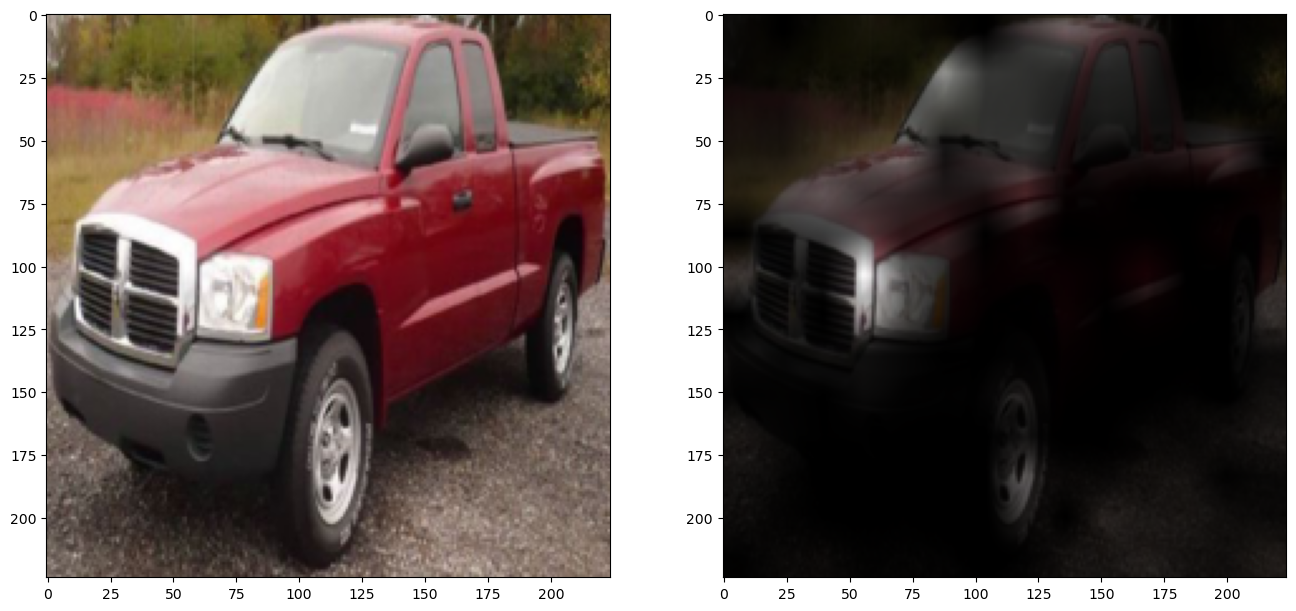

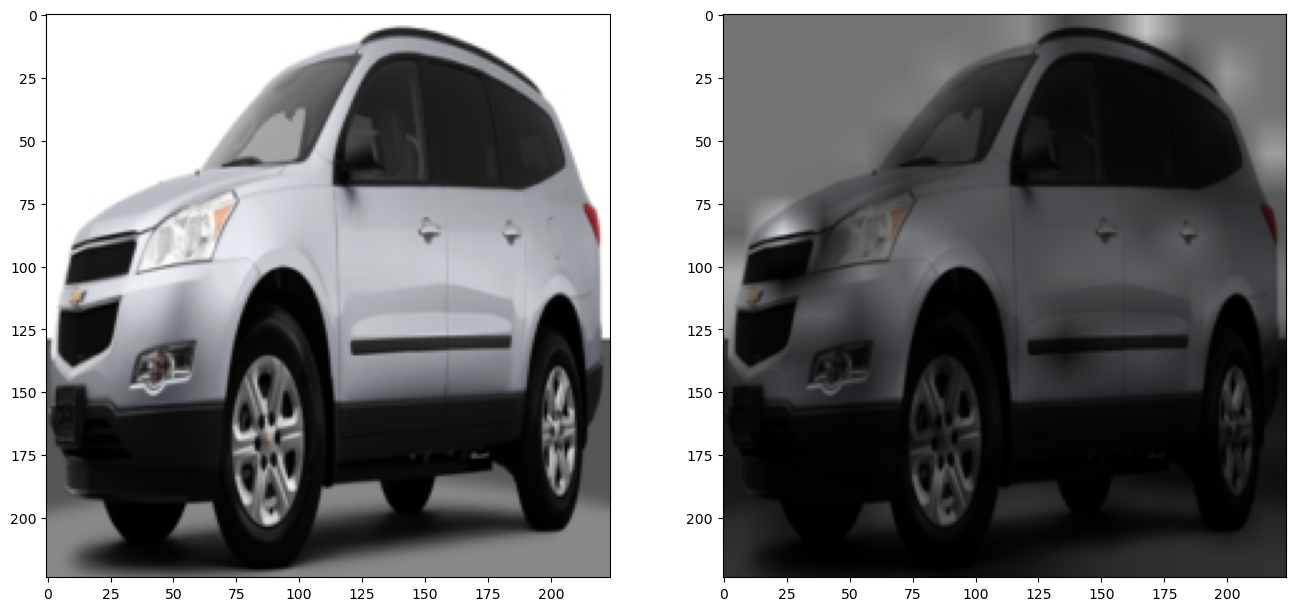

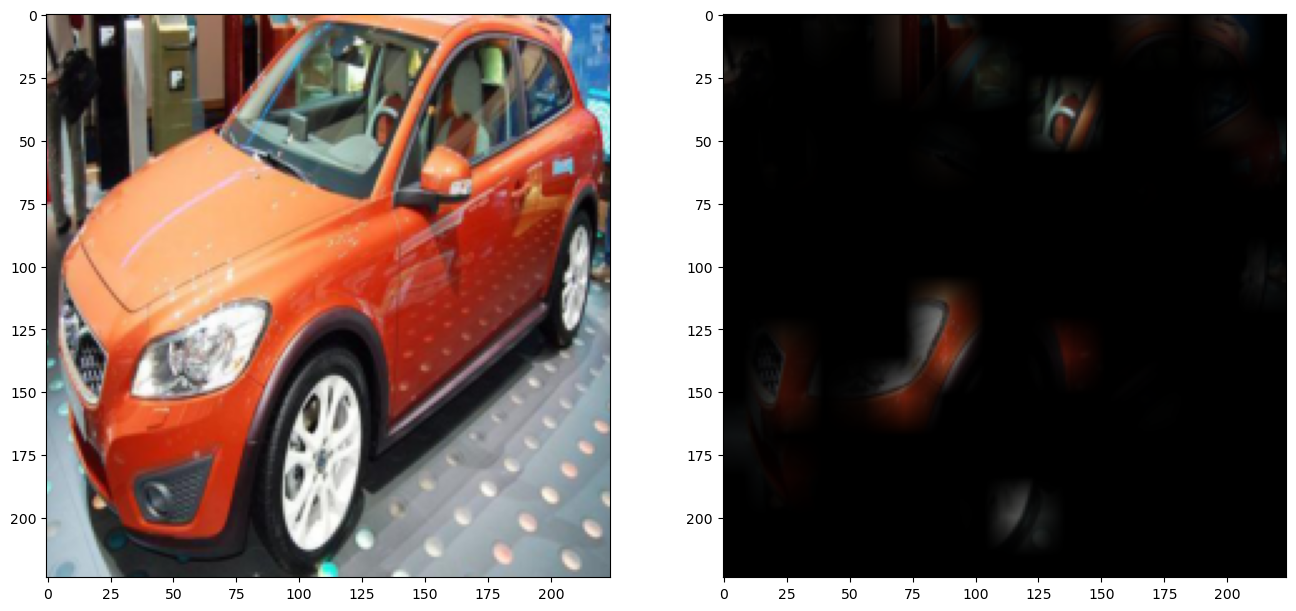

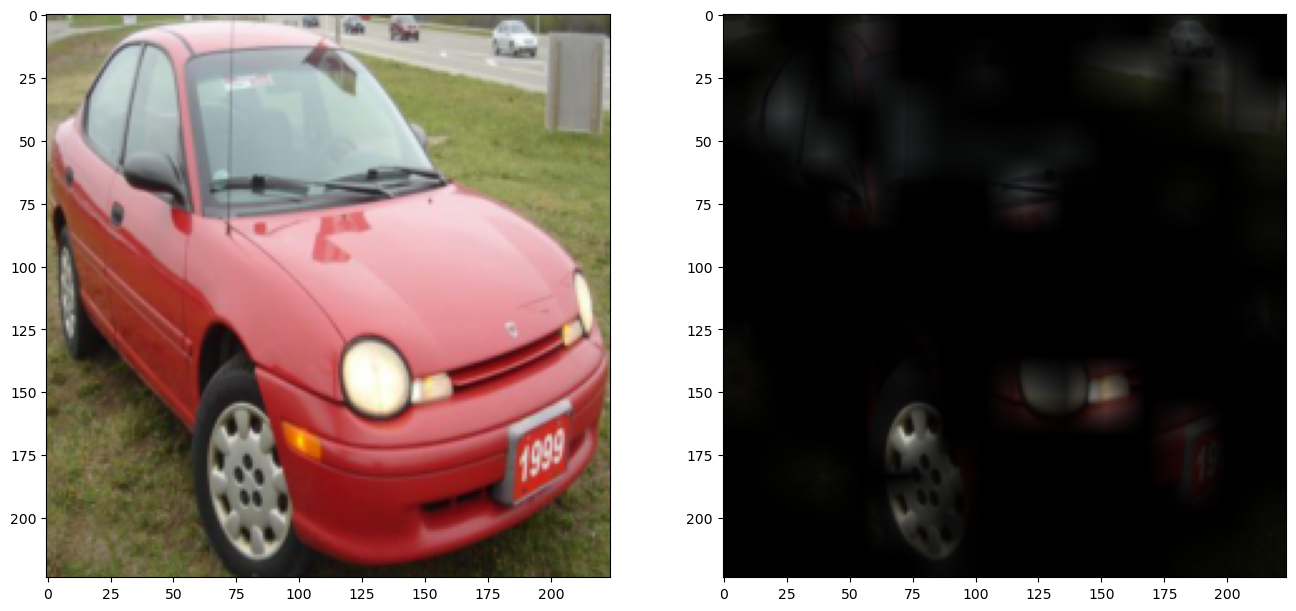

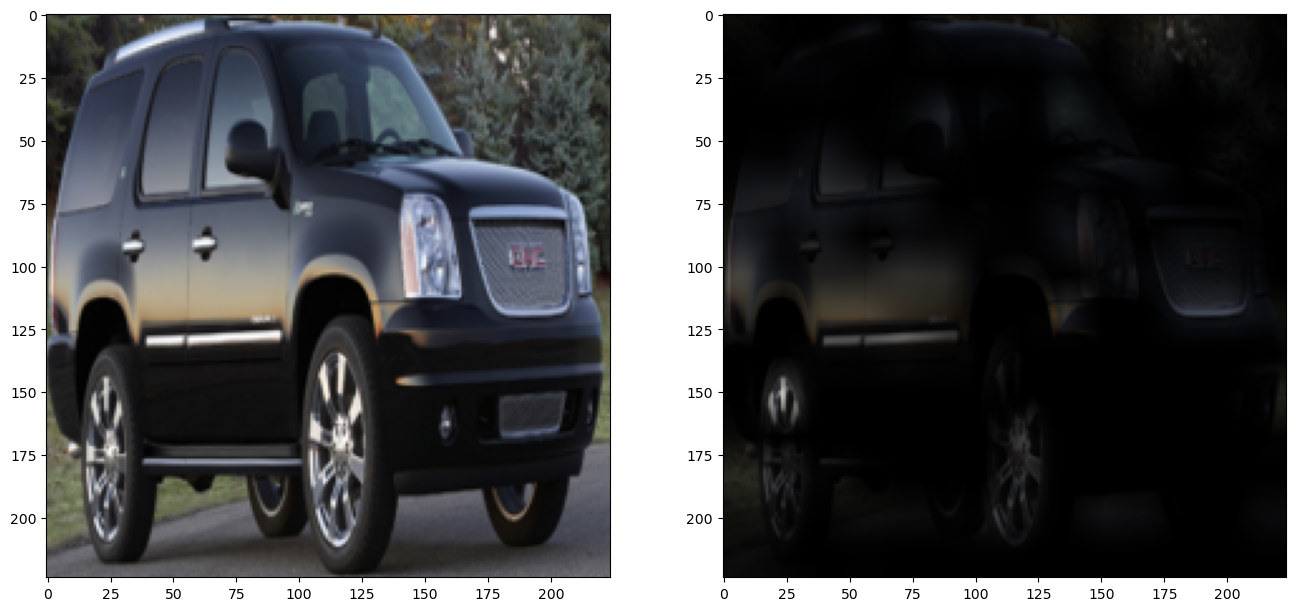

In [15]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget


class ModelGradCAM(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, x):
        if len(x.shape) != 4:
            x = x.unsqueeze(0)
        return self.model(x)


model_gradcam = ModelGradCAM(model)
for idx in range(5):
    input_tensor, target = test_dataset[idx]
    with GradCAM(model=model_gradcam, target_layers=[model.conv_proj]) as cam:
        car_grayscale_cam = cam(
            input_tensor=input_tensor, targets=[ClassifierOutputTarget(target)]
        )

        f, (ax1, ax2) = plt.subplots(ncols=2)
        f.set_figheight(8)
        f.set_figwidth(16)
        ax1.imshow(np.transpose(input_tensor, (1, 2, 0)))
        ax2.imshow(np.transpose(input_tensor * car_grayscale_cam, (1, 2, 0)))
        plt.show()

Вывод:
- итоговая модель имеет достаточо большой precision и не очень хороший recall
- в качестве модели использовался небольшой трансформер, возможно для улучшения качестве стоит увеличить количество эпох обучения, а также попробовать более лучше настроить оптимизатор
- GradCam не очень подошел для трансформеров, поэтому была возможность визуализировать только первый сверточный слой, но даже так видно, что модель преимущественно смотрит на области, где находятся машины